## Beta Classifier

### Problem analysis

- **Type** => Supervised, classification problem
- **Input data location** => imagesDatabase
- **Input size** => 389 * 515 *3 (3 channel RGB)
- **Architecture** => CNN

### Todo

- Move to GPU https://pytorch.org/tutorials/beginner/nn_tutorial.html with dataloader collate_fn ?
- pretrain network ?


### Cell 1

- **Purpose** : Import libraries
- **Problems** : N/A
- **Notes** : N/A

In [1]:
import os
import numpy as np
import torch
from torch import nn
from torch.nn import ReLU
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torch.multiprocessing
from torchvision import datasets, transforms
from torchvision import models
from torch import optim
from torch.utils.data.dataloader import default_collate

from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import torchvision
import matplotlib.pyplot as plt
from colorama import Fore
from IPython.display import Audio, display
from torchsummary import summary
from tqdm.auto import tqdm
from timeit import default_timer as timer
import psutil

writer_path = 'runs/logger_classifier_beta_v2'
# writer to log to tensorboard
writer = SummaryWriter(writer_path)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Cell 2

- **Purpose** : Debug and Visualization functions
- **Problems** : N/A
- **Notes** : N/A

In [2]:
"""
Display spectrogram of an audio waveform.
@param waveform: Numpy waveform of sound
@param sample_rate: Sound sample rate
"""
def audio_display_spectrogram(waveform, sample_rate, title="Spectrogram", xlim=None) -> None:
    waveform = waveform.numpy()
    num_channels, _ = waveform.shape
    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

"""
Play sound of audio waveform.
@param waveform: Numpy waveform of sound
@param sample_rate: Sound sample rate
"""
def audio_play(waveform, sample_rate) -> None:
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

"""
Display a spectrogram image
@param img: Spectrogram of sound
@param one_channel: Whenever image is grey or has color (RGB) 
"""
def image_display_spectrogram(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
Display all the spectrogram of sounds within a batch
@param batches: Batch of data from a dataloader 
"""
def batches_display(batches, writer_path):
    dataiter = iter(batches)
    images, _ = next(dataiter)
    # create grid of images
    img_grid = torchvision.utils.make_grid(images)
    # show images
    image_display_spectrogram(img_grid, one_channel=False)
    # write to tensorboard
    writer.add_image(writer_path, img_grid)

"""
Log the size of each batch
@param batches: Batch of data from a dataloader 
"""
def batches_log_shape(batches):
    i = 0
    for curr_batch_image, _ in batches:
        print(Fore.GREEN, '[', '='*(i+1), ' '*(len(batches)-i-1), f'] Generated batch {i} with {len(curr_batch_image)} images')
        i += 1

### Cell 3

- **Purpose** : Select device for computation & set parameters
- **Problems** : N/A
- **Notes** : N/A

In [3]:
NUM_WORKERS = 4
QUICK_DEV = False
DATASET_PATH = '../database/2class_300samples'
# Load smaller database for faster loading time
if QUICK_DEV == True:
    DATASET_PATH = '../database/2class_30samples'
IMAGE_SIZE = (389, 515)
CHANNEL_COUNT = 3
ATTRIBUTION = ["chainsaw", "wild"]
SAVING_PATH = "../models/model_binary_beta_v1"
ACCURACY_THRESHOLD = 85

print("CUDA available" if torch.cuda.is_available() else "CUDA not available")
print("CPU available" if torch.backends.mps.is_available() else "CPU not available")
print("Metal apple device detected" if torch.backends.mps.is_built() else "No Metal apple device")

# Get CPU or GPU device for training.
if torch.cuda.is_available():
    compute_unit = torch.device("cuda")
elif torch.backends.mps.is_available():
    compute_unit = torch.device("mps")
else:
    compute_unit = torch.device("cpu")

# see https://github.com/pytorch/pytorch/issues/11201
torch.multiprocessing.set_sharing_strategy('file_system')
#torch.multiprocessing.set_start_method('spawn')

print(Fore.LIGHTMAGENTA_EX + f"Using {compute_unit} device for computation.")
print(Fore.GREEN + f"{compute_unit} workers count set to {NUM_WORKERS}")

CUDA not available
CPU available
Metal apple device detected
Using mps device for computation.
mps workers count set to 4


### Cell 4

- **Purpose** : Loading database and separate into Train / Test
- **Problems** : N/A
- **Notes** : N/A

In [4]:
# Define the data transformation
transform=transforms.ToTensor() 

# Load the dataset
print(Fore.LIGHTMAGENTA_EX + f"Loading images from dataset at {DATASET_PATH}")
dataset = datasets.ImageFolder(DATASET_PATH, transform=transform)

# train / test split
val_ratio = 0.2
val_size = int(val_ratio * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
print(Fore.GREEN + f"{train_size} images for training, {val_size} images for validation")

Loading images from dataset at ../database/2class_300samples
505 images for training, 126 images for validation


### Cell 5

- **Purpose** : Load data into batches 
- **Problems** : N/A
- **Notes** : If a database of 315 images for each class is loaded than it mean 630*0.8=504 images would be loaded for training, meaning if the batch size if 16 that it would be loaded among 504 / 16 = 32 batches which is a shitty coincidence that might be confusing as the shape would be (32, 16, 3, 389, 515) which really look like the first dimension is the batch size while its the number of batch.

Dataset loaded in batches.
Batch set to 16 for training
Batch set to 32 for validation


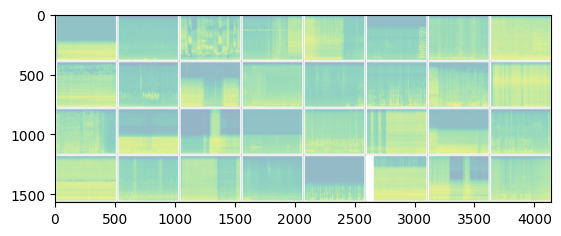

In [5]:
batch_size = 16


# Load into batches
train_batches = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=NUM_WORKERS,
                                           pin_memory=False) # switch to True if using collate

val_batches = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size*2,
                                         num_workers=NUM_WORKERS,
                                         pin_memory=False) # switch to True if using collate

print(Fore.LIGHTMAGENTA_EX + f"Dataset loaded in batches.")
print(Fore.GREEN + f"Batch set to {batch_size} for training")
print(Fore.GREEN + f"Batch set to {batch_size*2} for validation")
batches_display(val_batches, writer_path=writer_path)

### Cell 6

- **Purpose** : Define Neural Network Architecture 
- **Problems** : N/A
- **Notes** : N/A

In [7]:

# Define CNN as sequential
model_binary_v1_arch = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
    nn.Conv2d(10, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=480,
              out_features=2),
)

# define CNN as sequential
class neuralNetworkV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1) 
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1) 
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(10, 10, kernel_size=3, stride=2, padding=1)
        self.pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) 
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=480, out_features=2)
    
    def forward(self, x: torch.Tensor):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pooling(x)
        x = self.relu(self.conv3(x))
        x = self.pooling(x)
        x = self.relu(self.conv4(x))
        x = self.flatten(x)
        try:
            x = self.linear(x)
        except Exception as e:
            print(Fore.RED + f"Error : Linear block should take support shape of {x.shape} for in_features.")
        return x

#selected_model = model_binary_v1_arch.to(compute_unit)
selected_model = neuralNetworkV1()

# Add CNN info to tensorboard
train_images_sample, _ = next(iter(train_batches))
writer.add_graph(selected_model, train_images_sample)

print(Fore.LIGHTMAGENTA_EX + f"Training dataloader shape :")
print(Fore.GREEN + f"({len(train_batches)}, {len(train_images_sample)}, {len(train_images_sample[0])}, {len(train_images_sample[0][0])}, {len(train_images_sample[0][0][0])})")

print(Fore.LIGHTMAGENTA_EX + "Model summary : " + Fore.GREEN)
print(summary(selected_model, (CHANNEL_COUNT, IMAGE_SIZE[0], IMAGE_SIZE[1])))

Training dataloader shape :
(32, 16, 3, 389, 515)
Model summary : 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 195, 258]             448
              ReLU-2         [-1, 16, 195, 258]               0
            Conv2d-3          [-1, 16, 98, 129]           2,320
              ReLU-4          [-1, 16, 98, 129]               0
         MaxPool2d-5           [-1, 16, 49, 64]               0
            Conv2d-6           [-1, 10, 25, 32]           1,450
              ReLU-7           [-1, 10, 25, 32]               0
         MaxPool2d-8           [-1, 10, 12, 16]               0
            Conv2d-9             [-1, 10, 6, 8]             910
             ReLU-10             [-1, 10, 6, 8]               0
          Flatten-11                  [-1, 480]               0
           Linear-12                    [-1, 2]             962
Total params: 6,090
Trainable params

### Cell 7

- **Purpose** : Model training 
- **Problems** : N/A 
- **Notes** : Overtrain_neural_netting start at around 90 epochs on 316 images database.
              Overtrain_neural_netting start at around 30 epochs on 50 images database.
              Theoritical loss for first epoch should be ln (1 / numclasses)

In [ ]:
# display total time training
def display_training_time(start, end, device):
    total_time = end - start
    print(Fore.LIGHTMAGENTA_EX + f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.
    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.
    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Display training infos for each epochs
def display_training_infos(epoch, val_loss, train_loss, accuracy):
    val_loss = round(val_loss.item(), 3)
    train_loss = round(train_loss.item(), 3)
    accuracy = round(accuracy, 2)
    print(Fore.GREEN + f"Epoch : {epoch}, Training loss : {train_loss}, Validation loss : {val_loss}, Accuracy : {accuracy} %")

# Check memory usage excess
def check_memory():
    mem_percent = psutil.virtual_memory().percent
    swap_percent = psutil.swap_memory().percent
    if mem_percent >= 90:
        print(Fore.YELLOW + f"WARNING : Reached {mem_percent} memory usage !")
        os.system(f'say "Memory usage high"')
    if swap_percent >= 90:
        print(Fore.YELLOW + f"WARNING : Reached {mem_percent} memory usage !")
        os.system(f'say "Swap usage high"')
    if mem_percent >= 95 and swap_percent >= 95:
        print(Fore.RED + f"ABORTING : Memory and Swap full !")
        os.system(f'say "Aborting training"')
        raise MemoryError

def train_neural_net(epochs, model, loss_func, optimizer, train_batches, val_batches):
    last_loss = 0
    final_accuracy = 0
    for epoch in tqdm(range(epochs)):
        # check memory and swap usage
        check_memory()
        # training mode
        model.train()
        with torch.enable_grad():
            train_loss = 0
            for images, labels in train_batches:
                predictions = model(images)
                loss = loss_func(predictions, labels)
                train_loss += loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            train_loss /= len(train_batches)
            writer.add_scalar("training loss", train_loss, epoch)
        # evaluation mode
        val_loss, val_accuracy = 0, 0
        model.eval()
        with torch.inference_mode():
            for images, labels in val_batches:
                #images, labels = images.to(compute_unit), labels.to(compute_unit)
                predictions = model(images)
                val_loss += loss_func(predictions, labels)
                val_accuracy += accuracy_fn(y_true=labels, y_pred=predictions.argmax(dim=1))
            val_loss /= len(val_batches)
            val_accuracy /= len(val_batches)
            writer.add_scalar("validation loss", val_loss, epoch)
            final_accuracy = val_accuracy
        display_training_infos(epoch+1, val_loss, train_loss, val_accuracy)
        writer.add_scalar("accuracy", val_accuracy, epoch)
        if val_accuracy >= ACCURACY_THRESHOLD:
            break
        last_loss = val_loss
    return final_accuracy

MAX_EPOCHS = 300
LEARNING_RATE = 0.01
GRADIENT_MOMENTUM = 0.90
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(selected_model.parameters(), lr=LEARNING_RATE, momentum=GRADIENT_MOMENTUM)

print(Fore.LIGHTMAGENTA_EX + "Model ready : ")
print(Fore.GREEN, f"Learning rate set to : {LEARNING_RATE}")
print(Fore.GREEN, f"Momentum set to : {GRADIENT_MOMENTUM}")

print(Fore.LIGHTMAGENTA_EX + "Starting model training...")
train_time_start_on_gpu = timer()
training_complete = False
model_accuracy = train_neural_net(MAX_EPOCHS, selected_model, loss_func, optimizer, train_batches, val_batches)
print(Fore.LIGHTCYAN_EX + f"Training complete : {model_accuracy} %")
os.system(f'say "Training complete"')
training_complete = True
display_training_time(start=train_time_start_on_gpu,
                  end=timer(),
                  device=compute_unit)

Model ready : 
 Learning rate set to : 0.01
 Momentum set to : 0.9
Starting model training...


  0%|          | 1/300 [00:52<4:19:23, 52.05s/it]

Epoch : 1, Training loss : 0.696, Validation loss : 0.694, Accuracy : 48.54, Threads : 0 


### Cell 8

- **Purpose** : Model saving 
- **Problems** : N/A 
- **Notes** : N/A 

In [ ]:
if training_complete == True:
    if input("Save model ? y for YES") == "y":
        print(Fore.LIGHTMAGENTA_EX + f"Saving model at {SAVING_PATH}")
        torch.save(selected_model, SAVING_PATH)
writer.flush()
writer.close()

Saving model at ../models/model_binary_beta_v1
